In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from model import PyTorchModel_defended, PyTorchModel

In [2]:
# Hyperparameters
batchSize = 1

In [3]:
model_defended = PyTorchModel_defended()
model_defended.load_state_dict(torch.load('model_pytorch_defended_i3.pth'))

model_undefended = PyTorchModel()
model_undefended.load_state_dict(torch.load('model_pytorch.pth'))

<All keys matched successfully>

In [4]:
testX = np.load('testData.npy')
testY = np.load('groundTruth.npy')
trainX = np.load('trainData.npy')
trainY = np.load('trainLabels.npy')

# Convert the training and testing data to PyTorch tensors
trainX_torch = torch.from_numpy(np.transpose(trainX, (0, 3, 1, 2))).float()
trainY_torch = torch.from_numpy(np.argmax(trainY, axis=1)).long()
testX_torch = torch.from_numpy(np.transpose(testX, (0, 3, 1, 2))).float()
testY_torch = torch.from_numpy(np.argmax(testY, axis=1)).long()

# Create TensorDatasets for training and testing data
train_data = TensorDataset(trainX_torch, trainY_torch)
test_data = TensorDataset(testX_torch, testY_torch)

# Create DataLoaders for training and testing data
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batchSize, shuffle=False)

In [5]:
#get min max of trainX
min_trainX = np.min(trainX)
max_trainX = np.max(trainX)
print(min_trainX, max_trainX)

-4.322391471376455 4.085751745014715


In [6]:
# In this notebook we will perform Adversarial Patch attack on the model, by treating a training sample as a 2D image (90 X 3) and placing a patch on it.
# We will use the PyTorch framework to implement the attack.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def plot_sample(sample):
    sample = np.transpose(sample.detach().numpy())
    plt.imshow(sample, aspect='auto')
    plt.show()

In [8]:
criterion = nn.CrossEntropyLoss()
def fgsm_attack(model, data, labels, epsilon):
    if epsilon == 0:
        return data
    
    data.requires_grad = True # Set requires_grad attribute of tensor to true because we need to compute the gradient w.r.t to the input data
    outputs = model(data) # Forward pass
    init_pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
    #if init_pred.item() != labels.item(): # If the initial prediction is wrong, don't bother attacking, just move on
    #    return data
    #loss = F.nll_loss(outputs, labels) # Calculate the loss
    loss = criterion(outputs, labels)
    model.zero_grad() # Zero all existing gradients
    loss.backward() # Calculate gradients of model in backward pass
    data_grad = data.grad.data # Collect datagrad
    sign_data_grad = data_grad.sign()
    perturbed_data = data + epsilon*sign_data_grad # Create the perturbed image by adjusting each pixel of the input image    
    
    #TODO: Have a look at the range of original data and adjust accordingly, is it necessary to clip to our range?
    #perturbed_data = torch.clamp(perturbed_data, 0, 1) # Adding clipping to maintain [0,1] range

    return perturbed_data

In [9]:
def test_fgsm_attack(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []

    for data, target in tqdm(test_loader, desc="Processing batches"): # Loop over all examples in test set
        data, target = data.to(device), target.to(device) # Send the data and label to the device
        outputs = model(data) # Calculate initial prediction
        init_pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability

        perturbed_data = fgsm_attack(model, data, target, epsilon)  # Call FGSM Attack
        output = model(perturbed_data) # Re-classify the perturbed image
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      
        if final_pred.item() == target.item():
            correct += 1
        
        # Save some adv examples for visualization later
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {}".format(epsilon, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [10]:
# Single test of the attack
epsilon = 0.1
final_acc, adv_examples = test_fgsm_attack(model_defended, device, test_loader, epsilon)
#print("Final Accuracy on adversarial examples: ", final_acc)

Processing batches: 100%|██████████| 4891/4891 [01:47<00:00, 45.54it/s]

Epsilon: 0.1	Test Accuracy = 0.7575138008587201
Final Accuracy on adversarial examples:  0.7575138008587201


In [10]:
# Multiple attack runs for different epsilon values
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, .45, .5]
epsilon_exs_undef = dict() #dictionary to store adversarial examples for each epsilon
epsilon_exs_def = dict() 
epsilon_acc_undef = dict() #dictionary to store undefended accuracy for each epsilon
epsilon_acc_def = dict() #dictionary to store defended accuracy

for e in epsilons:
    acc, adv_exs = test_fgsm_attack(model_undefended, device, test_loader, e)
    epsilon_exs_undef[e] = adv_exs
    epsilon_acc_undef[e] = acc
    
    acc, adv_exs = test_fgsm_attack(model_defended, device, test_loader, e)
    epsilon_exs_def[e] = adv_exs
    epsilon_acc_def[e] = acc

Processing batches: 100%|██████████| 4891/4891 [00:16<00:00, 294.05it/s]


Epsilon: 0	Test Accuracy = 0.9143324473522797


Processing batches: 100%|██████████| 4891/4891 [00:41<00:00, 117.75it/s]


Epsilon: 0	Test Accuracy = 0.897158045389491


Processing batches: 100%|██████████| 4891/4891 [00:41<00:00, 117.84it/s]


Epsilon: 0.05	Test Accuracy = 0.7763238601512983


Processing batches: 100%|██████████| 4891/4891 [02:02<00:00, 39.83it/s]


Epsilon: 0.05	Test Accuracy = 0.8521774688202821


Processing batches: 100%|██████████| 4891/4891 [00:41<00:00, 119.07it/s]


Epsilon: 0.1	Test Accuracy = 0.6133714986710285


Processing batches: 100%|██████████| 4891/4891 [02:02<00:00, 39.88it/s]


Epsilon: 0.1	Test Accuracy = 0.7724391739930485


Processing batches: 100%|██████████| 4891/4891 [00:41<00:00, 118.46it/s]


Epsilon: 0.15	Test Accuracy = 0.4894704559394807


Processing batches: 100%|██████████| 4891/4891 [02:07<00:00, 38.50it/s]


Epsilon: 0.15	Test Accuracy = 0.669801676548763


Processing batches: 100%|██████████| 4891/4891 [00:43<00:00, 111.21it/s]


Epsilon: 0.2	Test Accuracy = 0.3960335309752607


Processing batches: 100%|██████████| 4891/4891 [02:17<00:00, 35.63it/s]


Epsilon: 0.2	Test Accuracy = 0.595379268043345


Processing batches: 100%|██████████| 4891/4891 [00:47<00:00, 103.84it/s]


Epsilon: 0.25	Test Accuracy = 0.33735432426906564


Processing batches: 100%|██████████| 4891/4891 [02:07<00:00, 38.34it/s]


Epsilon: 0.25	Test Accuracy = 0.5156409732161112


Processing batches: 100%|██████████| 4891/4891 [00:42<00:00, 116.22it/s]


Epsilon: 0.3	Test Accuracy = 0.28153751789000203


Processing batches: 100%|██████████| 4891/4891 [02:10<00:00, 37.48it/s]


Epsilon: 0.3	Test Accuracy = 0.47454508280515234


Processing batches: 100%|██████████| 4891/4891 [00:48<00:00, 101.66it/s]


Epsilon: 0.35	Test Accuracy = 0.25843385810672664


Processing batches: 100%|██████████| 4891/4891 [02:16<00:00, 35.71it/s]


Epsilon: 0.35	Test Accuracy = 0.410345532610918


Processing batches: 100%|██████████| 4891/4891 [00:40<00:00, 120.72it/s]


Epsilon: 0.4	Test Accuracy = 0.2244939685135964


Processing batches: 100%|██████████| 4891/4891 [02:05<00:00, 39.01it/s]


Epsilon: 0.4	Test Accuracy = 0.3753833571866694


Processing batches: 100%|██████████| 4891/4891 [00:46<00:00, 106.11it/s]


Epsilon: 0.45	Test Accuracy = 0.22551625434471478


Processing batches: 100%|██████████| 4891/4891 [02:06<00:00, 38.59it/s]


Epsilon: 0.45	Test Accuracy = 0.352893068902065


Processing batches: 100%|██████████| 4891/4891 [00:40<00:00, 120.21it/s]


Epsilon: 0.5	Test Accuracy = 0.2202003680228992


Processing batches: 100%|██████████| 4891/4891 [02:01<00:00, 40.38it/s]

Epsilon: 0.5	Test Accuracy = 0.33776323860151297


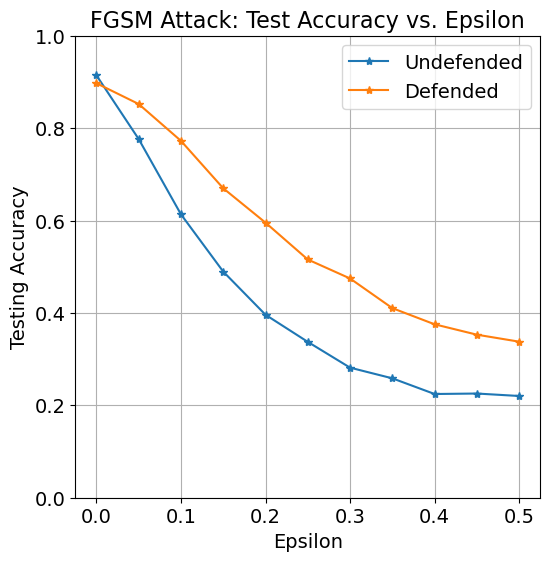

In [12]:
# Plot accuracy vs epsilon values
plt.figure(figsize=(6,6))
plt.plot(list(epsilon_acc_undef.keys()), list(epsilon_acc_undef.values()), "*-", label="Undefended")
plt.plot(list(epsilon_acc_def.keys()), list(epsilon_acc_def.values()), "*-", label="Defended")
plt.yticks(np.arange(0, 1.1, step=0.2), fontsize=14)
plt.xticks(np.arange(0, .55, step=0.1), fontsize=14)
plt.title("FGSM Attack: Test Accuracy vs. Epsilon",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.xlabel("Epsilon", fontsize=14), plt.ylabel("Testing Accuracy", fontsize=14)

plt.savefig('fgsm_attack.png')

plt.show()



In [13]:
#TODO: get data before normalisation

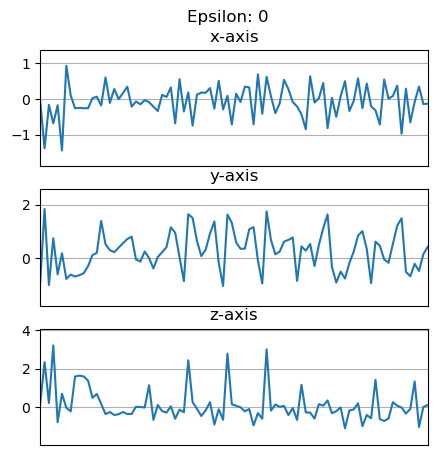

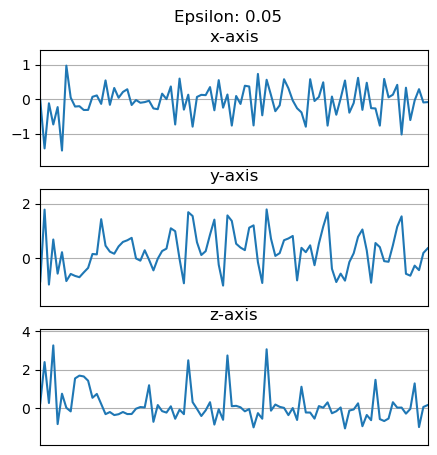

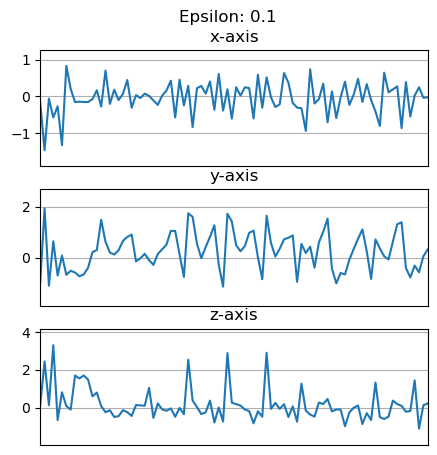

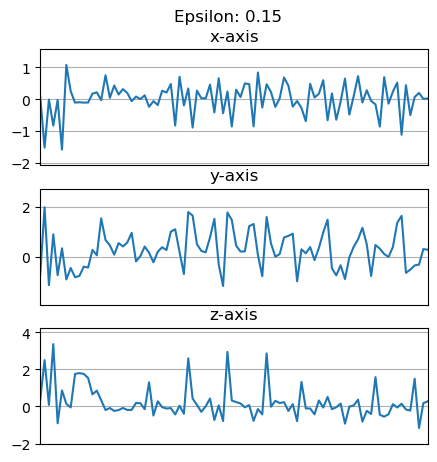

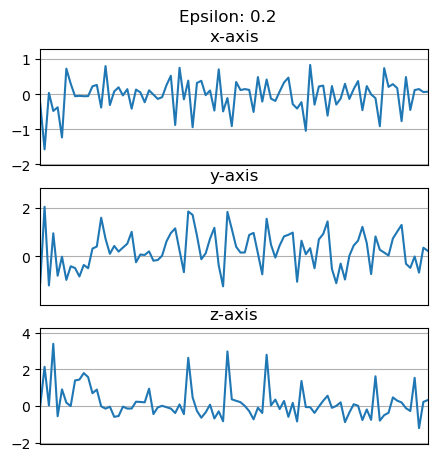

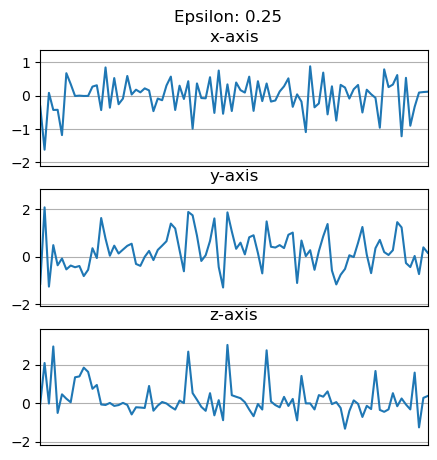

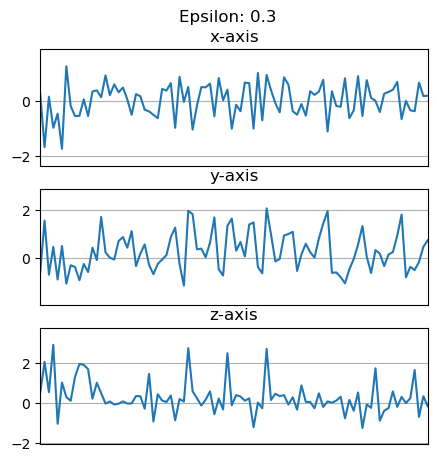

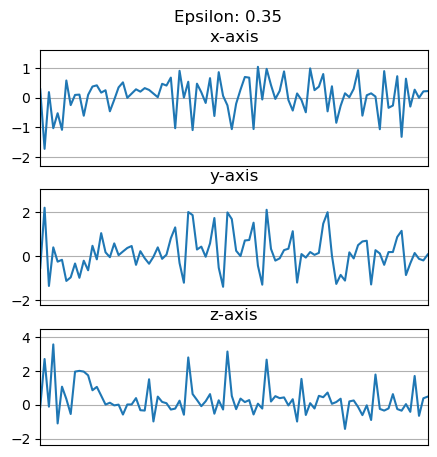

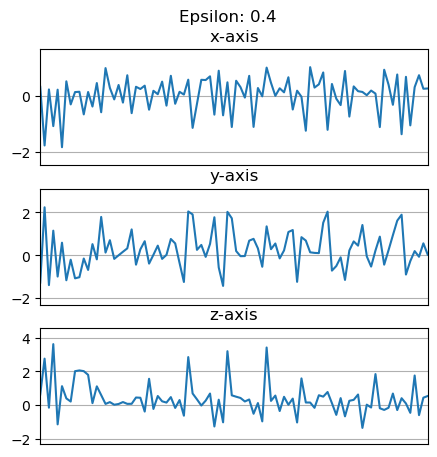

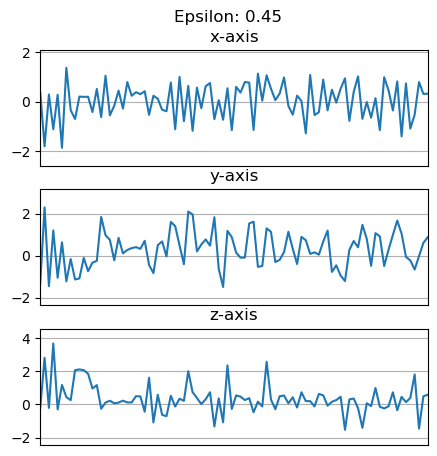

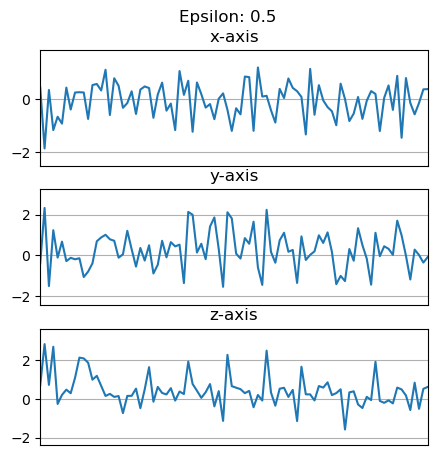

In [14]:
#TODO: plot some adversarial examples for each epsilon
#print(epsilon_exs[0.2][0][2].shape) #shape of one adversarial example, how to access example

def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)
# defining a function to plot the data for a given activity
def plotActivity(activity,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(5,5),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

for e, exs in epsilon_exs_def.items():

    orig, adv, ex = exs[0]
    ex = np.transpose(ex)
   
    sampling_freq = 20 #Hz
    time_axis = np.arange(0,90)/sampling_freq
    
    plotActivity(f"Epsilon: {e}", {'timestamp':time_axis,'x-axis':ex[0],'y-axis':ex[1],'z-axis':ex[2]})


